# Train an AI to solve the Frozen Lake environment

[Q-learning for beginners](https://mlabonne.github.io/blog/reinforcement%20learning/q-learning/frozen%20lake/gym/tutorial/2022/02/13/Q_learning.html)

In [21]:
import random

import gym
import numpy as np

gym.__version__

'0.26.2'

# Non-slippery

In [5]:
environment = gym.make("FrozenLake-v1", is_slippery=False)
environment.reset()
environment.render()

# Our table has the following dimensions:
# (rows x columns) = (states x actions) = (16 x 4)
qtable = np.zeros((16, 4))

# Alternatively, the gym library can also directly g
# give us the number of states and actions using
# "env.observation_space.n" and "env.action_space.n"
nb_states = environment.observation_space.n  # = 16
nb_actions = environment.action_space.n  # = 4
qtable = np.zeros((nb_states, nb_actions))

# Let's see how it looks
print('\nQ-table =')
print(qtable)

random.choice(["LEFT", "DOWN", "RIGHT", "UP"])

environment.action_space.sample()

environment.step(2)
environment.render()

action = environment.action_space.sample()

# 2. Implement this action and move the agent in the desired direction
new_state, reward, done, _, info = environment.step(action)

# Display the results (reward and map)
environment.render()
print(f'\nReward = {reward}')



Q-table =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Reward = 0.0


In [6]:
import matplotlib.pyplot as plt

# TODO: MAKE IT RENDER
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 17})
plt.show()


In [8]:
# We re-initialize the Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor

# List of outcomes to plot
outcomes = []

print('\nQ-table before training:')
print(qtable)


Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [9]:
# Training
for _ in range(episodes):
    state = environment.reset()  # No.
    state = environment.action_space.sample()

    done = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not done:
        # print("\n=>", state)
        # Choose the action with the highest value in the current state
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        # If there's no best action (only zeros), take a random one
        else:
            action = environment.action_space.sample()

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes[-1] = "Success"

print()
print('===========================================')
print('Q-table after training:')
print(qtable)



Q-table after training:
[[0.         0.         0.53835357 0.        ]
 [0.         0.         0.58495825 0.        ]
 [0.         0.69310433 0.         0.        ]
 [0.49792973 0.         0.         0.        ]
 [0.         0.         0.         0.49328087]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9        0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.225      0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]]


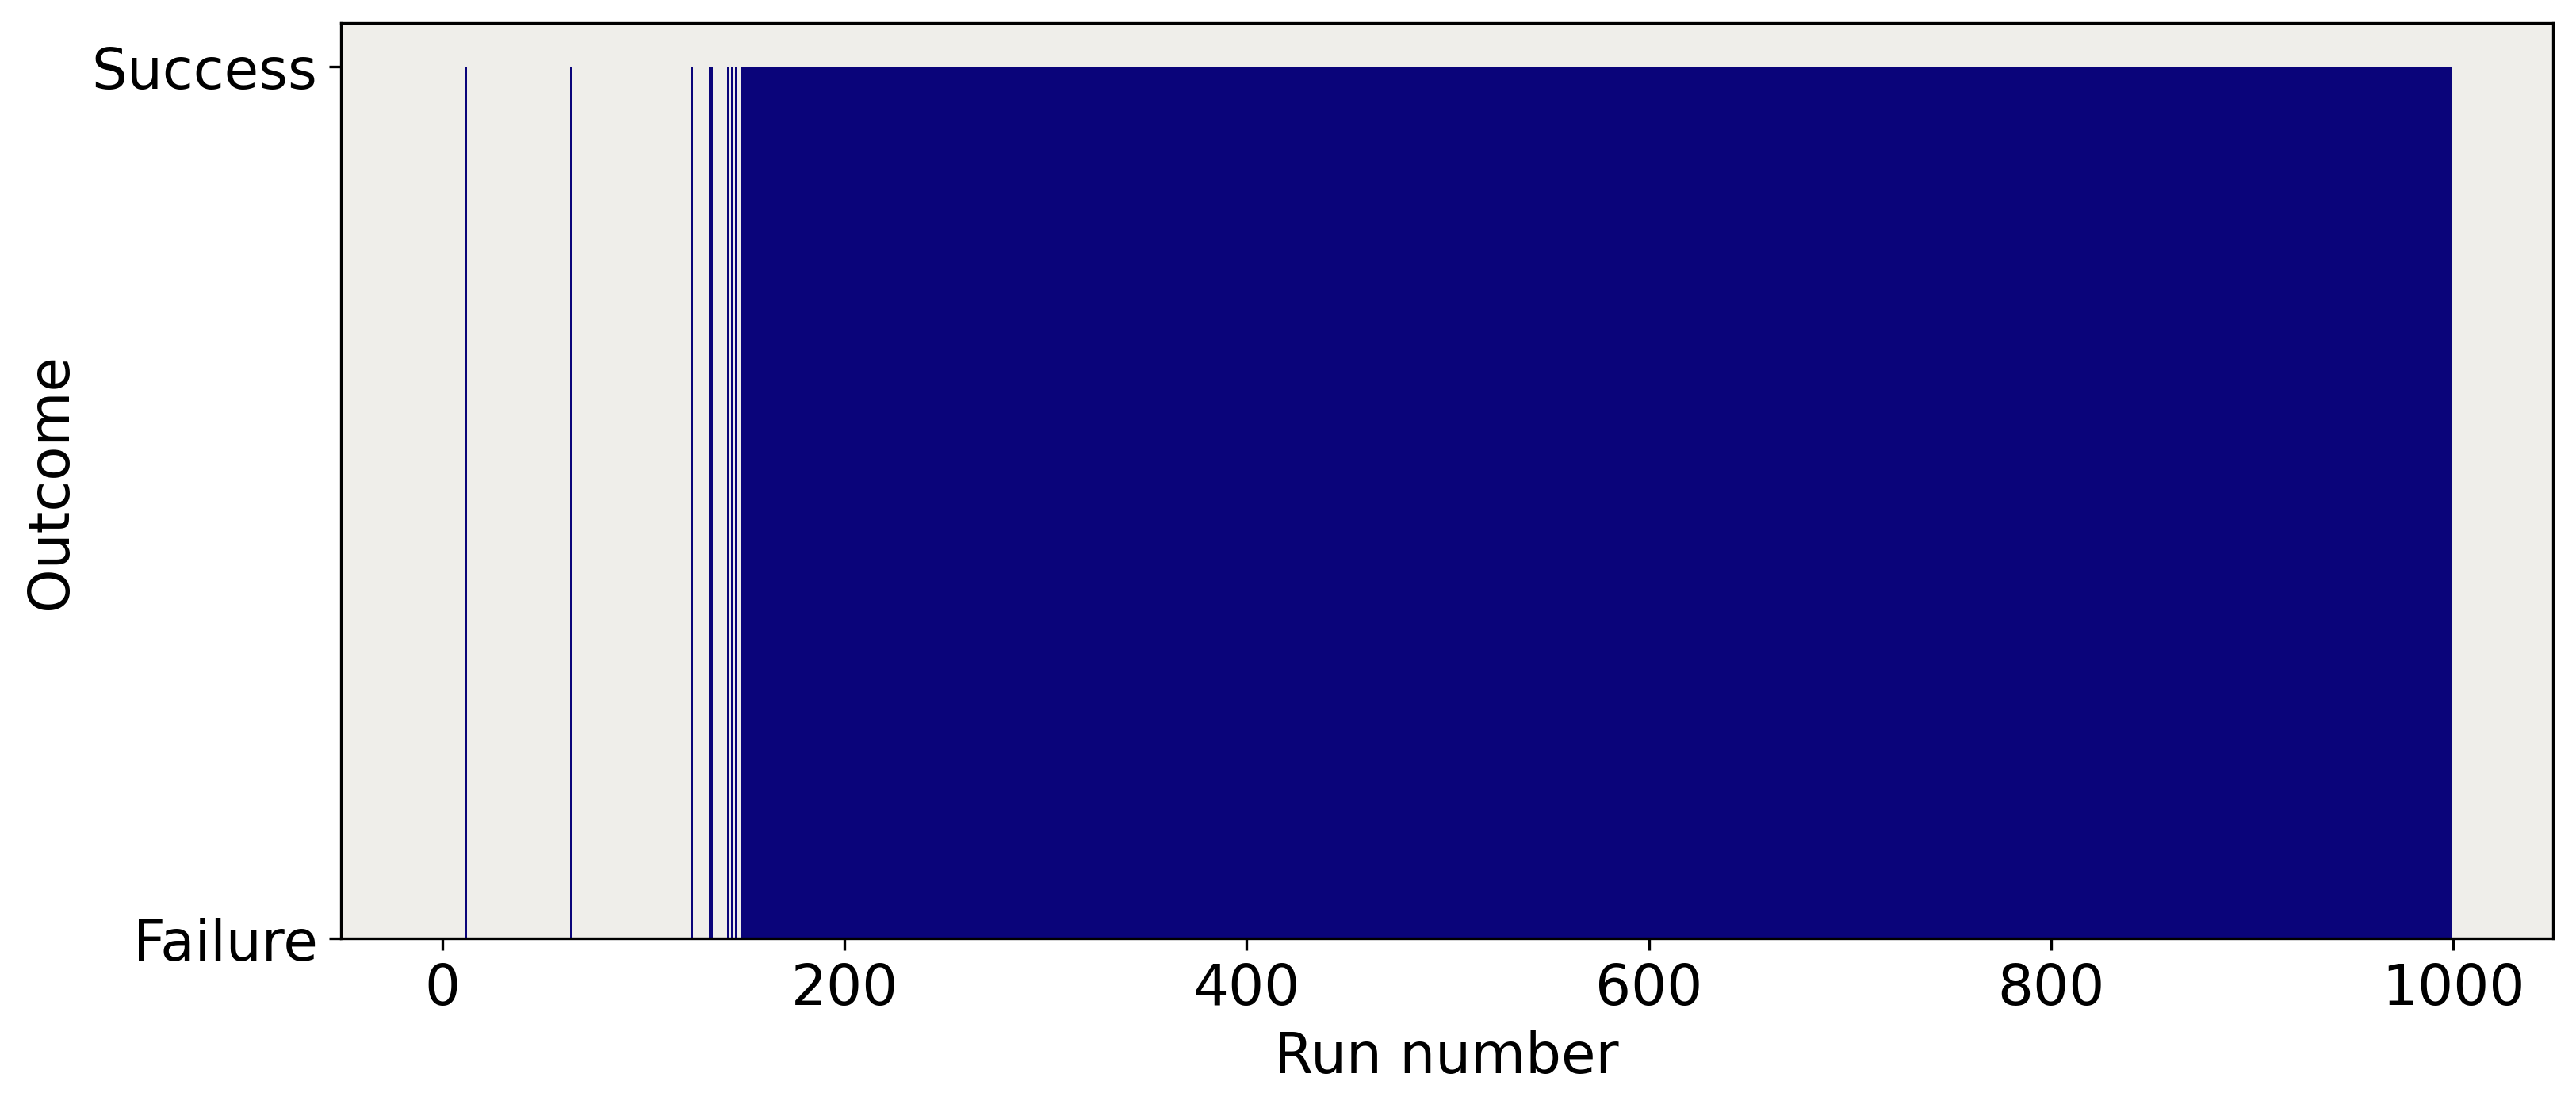

In [10]:
# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()


In [11]:
# Evaluation

episodes = 100
nb_success = 0

for _ in range(100):
    state = environment.reset()
    state = environment.action_space.sample()
    done = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        # If there's no best action (only zeros), take a random one
        else:
            action = environment.action_space.sample()

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

# Let's check our success rate!
print(f"Success rate = {nb_success / episodes * 100}%")

Success rate = 100.0%


In [12]:
from IPython.display import clear_output
import time

state = environment.reset()
state = environment.action_space.sample()
done = False
sequence = []

while not done:
    # Choose the action with the highest value in the current state
    if np.max(qtable[state]) > 0:
        action = np.argmax(qtable[state])

    # If there's no best action (only zeros), take a random one
    else:
        action = environment.action_space.sample()

    # Add the action to the sequence
    sequence.append(action)

    # Implement this action and move the agent in the desired direction
    new_state, reward, done, _, info = environment.step(action)

    # Update our current state
    state = new_state

    # Update the render
    clear_output(wait=True)
    environment.render()
    time.sleep(1)

print(f"Sequence = {sequence}")

Sequence = [2, 2, 1, 1, 1, 2]


In [13]:
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Amount of randomness in the action selection
epsilon_decay = 0.001  # Fixed amount to decrease

# List of outcomes to plot
outcomes = []

print('Q-table before training:')
print(qtable)

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [14]:
# Training
for _ in range(episodes):
    state = environment.reset()
    state = environment.action_space.sample()
    done = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not done:
        # Generate a random number between 0 and 1
        rnd = np.random.random()

        # If random number < epsilon, take a random action
        if rnd < epsilon:
            action = environment.action_space.sample()
        # Else, take the action with the highest value in the current state
        else:
            action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes[-1] = "Success"

    # Update epsilon
    epsilon = max(epsilon - epsilon_decay, 0)

print()
print('===========================================')
print('Q-table after training:')
print(qtable)


Q-table after training:
[[0.531441   0.59049    0.47830941 0.531441  ]
 [0.531441   0.43361702 0.49025779 0.51725051]
 [0.53142507 0.59049    0.47832946 0.53148402]
 [0.531441   0.59049    0.47994515 0.53115874]
 [0.59049    0.6561     0.         0.531441  ]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.         0.63086782]
 [0.         0.         0.         0.        ]
 [0.6561     0.         0.729      0.59049   ]
 [0.6561     0.81       0.81       0.        ]
 [0.72899985 0.9        0.         0.72899989]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.9        0.729     ]
 [0.81       0.9        1.         0.81      ]
 [0.         0.         0.         0.        ]]


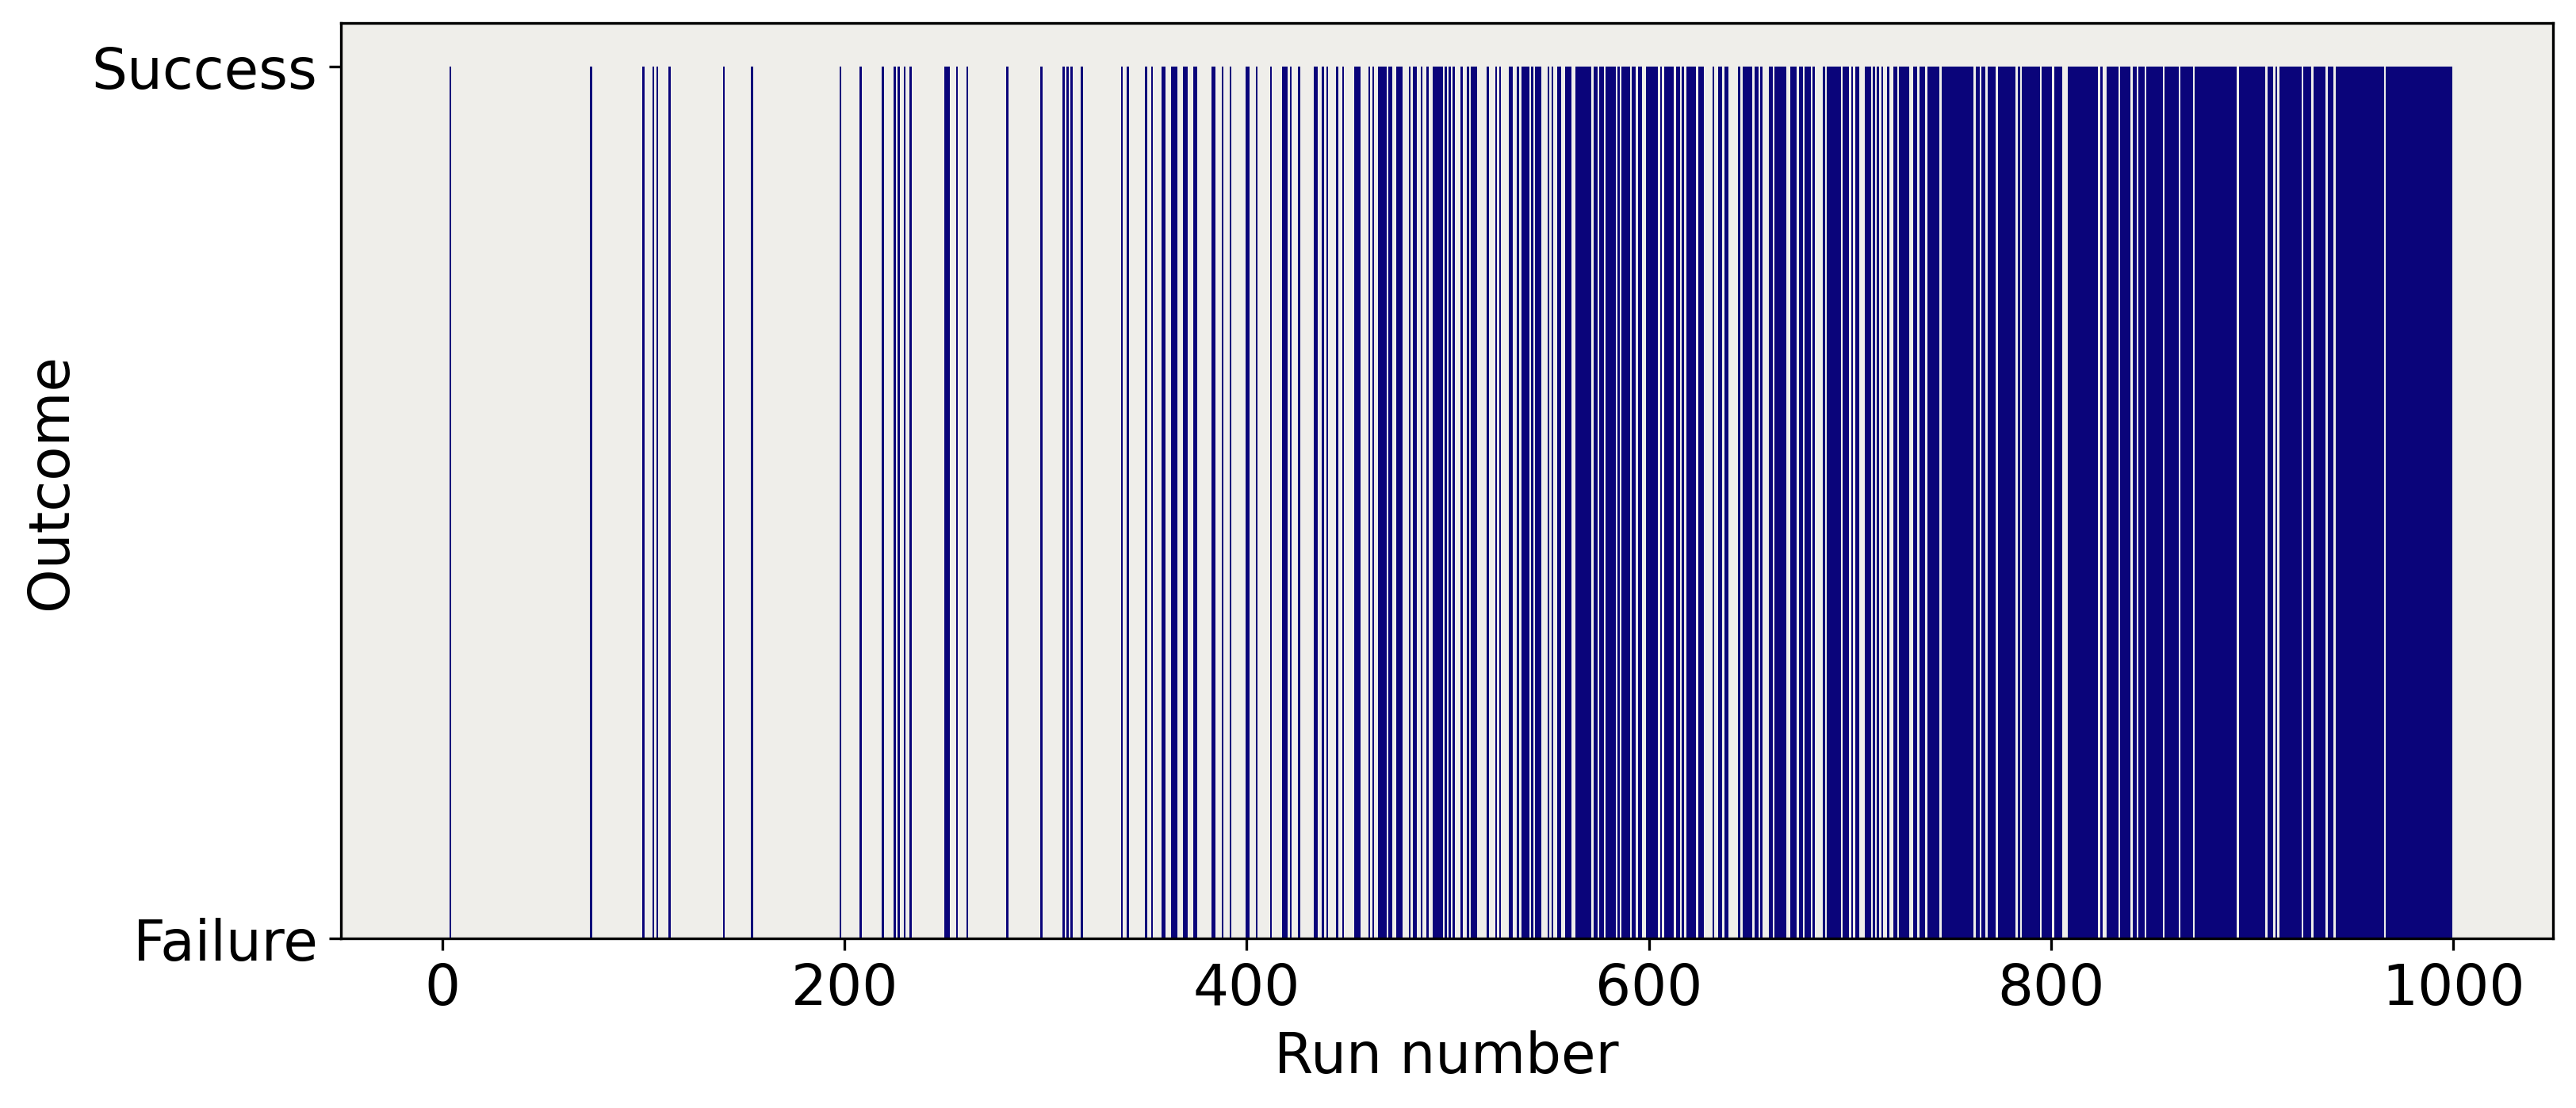

In [15]:
# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()

In [16]:
episodes = 100
nb_success = 0

# Evaluation
for _ in range(100):
    state = environment.reset()
    state = environment.action_space.sample()
    done = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

# Let's check our success rate!
print(f"Success rate = {nb_success / episodes * 100}%")

Success rate = 100.0%


# "Slippery"

In [17]:
environment = gym.make("FrozenLake-v1", is_slippery=True)
environment.reset()

# We re-initialize the Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Amount of randomness in the action selection
epsilon_decay = 0.001  # Fixed amount to decrease

# List of outcomes to plot
outcomes = []

print('Q-table before training:')
print(qtable)

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [18]:
# Training
for _ in range(episodes):
    state = environment.reset()
    state = environment.action_space.sample()
    done = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not done:
        # Generate a random number between 0 and 1
        rnd = np.random.random()

        # If random number < epsilon, take a random action
        if rnd < epsilon:
            action = environment.action_space.sample()
        # Else, take the action with the highest value in the current state
        else:
            action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes[-1] = "Success"

    # Update epsilon
    epsilon = max(epsilon - epsilon_decay, 0)

print()
print('===========================================')
print('Q-table after training:')
print(qtable)


Q-table after training:
[[0.05407183 0.047475   0.03164619 0.03198904]
 [0.01242716 0.01490325 0.0119052  0.05255307]
 [0.02550926 0.02467602 0.06222732 0.02772351]
 [0.02998606 0.01071338 0.02343005 0.04593318]
 [0.05196356 0.02691154 0.00531119 0.04583263]
 [0.         0.         0.         0.        ]
 [0.01126534 0.00960592 0.06443546 0.00634457]
 [0.         0.         0.         0.        ]
 [0.04816592 0.12178029 0.04791967 0.0866232 ]
 [0.03584229 0.26490319 0.06470549 0.09219403]
 [0.25172699 0.05352763 0.04632847 0.05221706]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.26685382 0.09737461 0.40073369 0.08482805]
 [0.31509146 0.59570247 0.37353732 0.44888638]
 [0.         0.         0.         0.        ]]


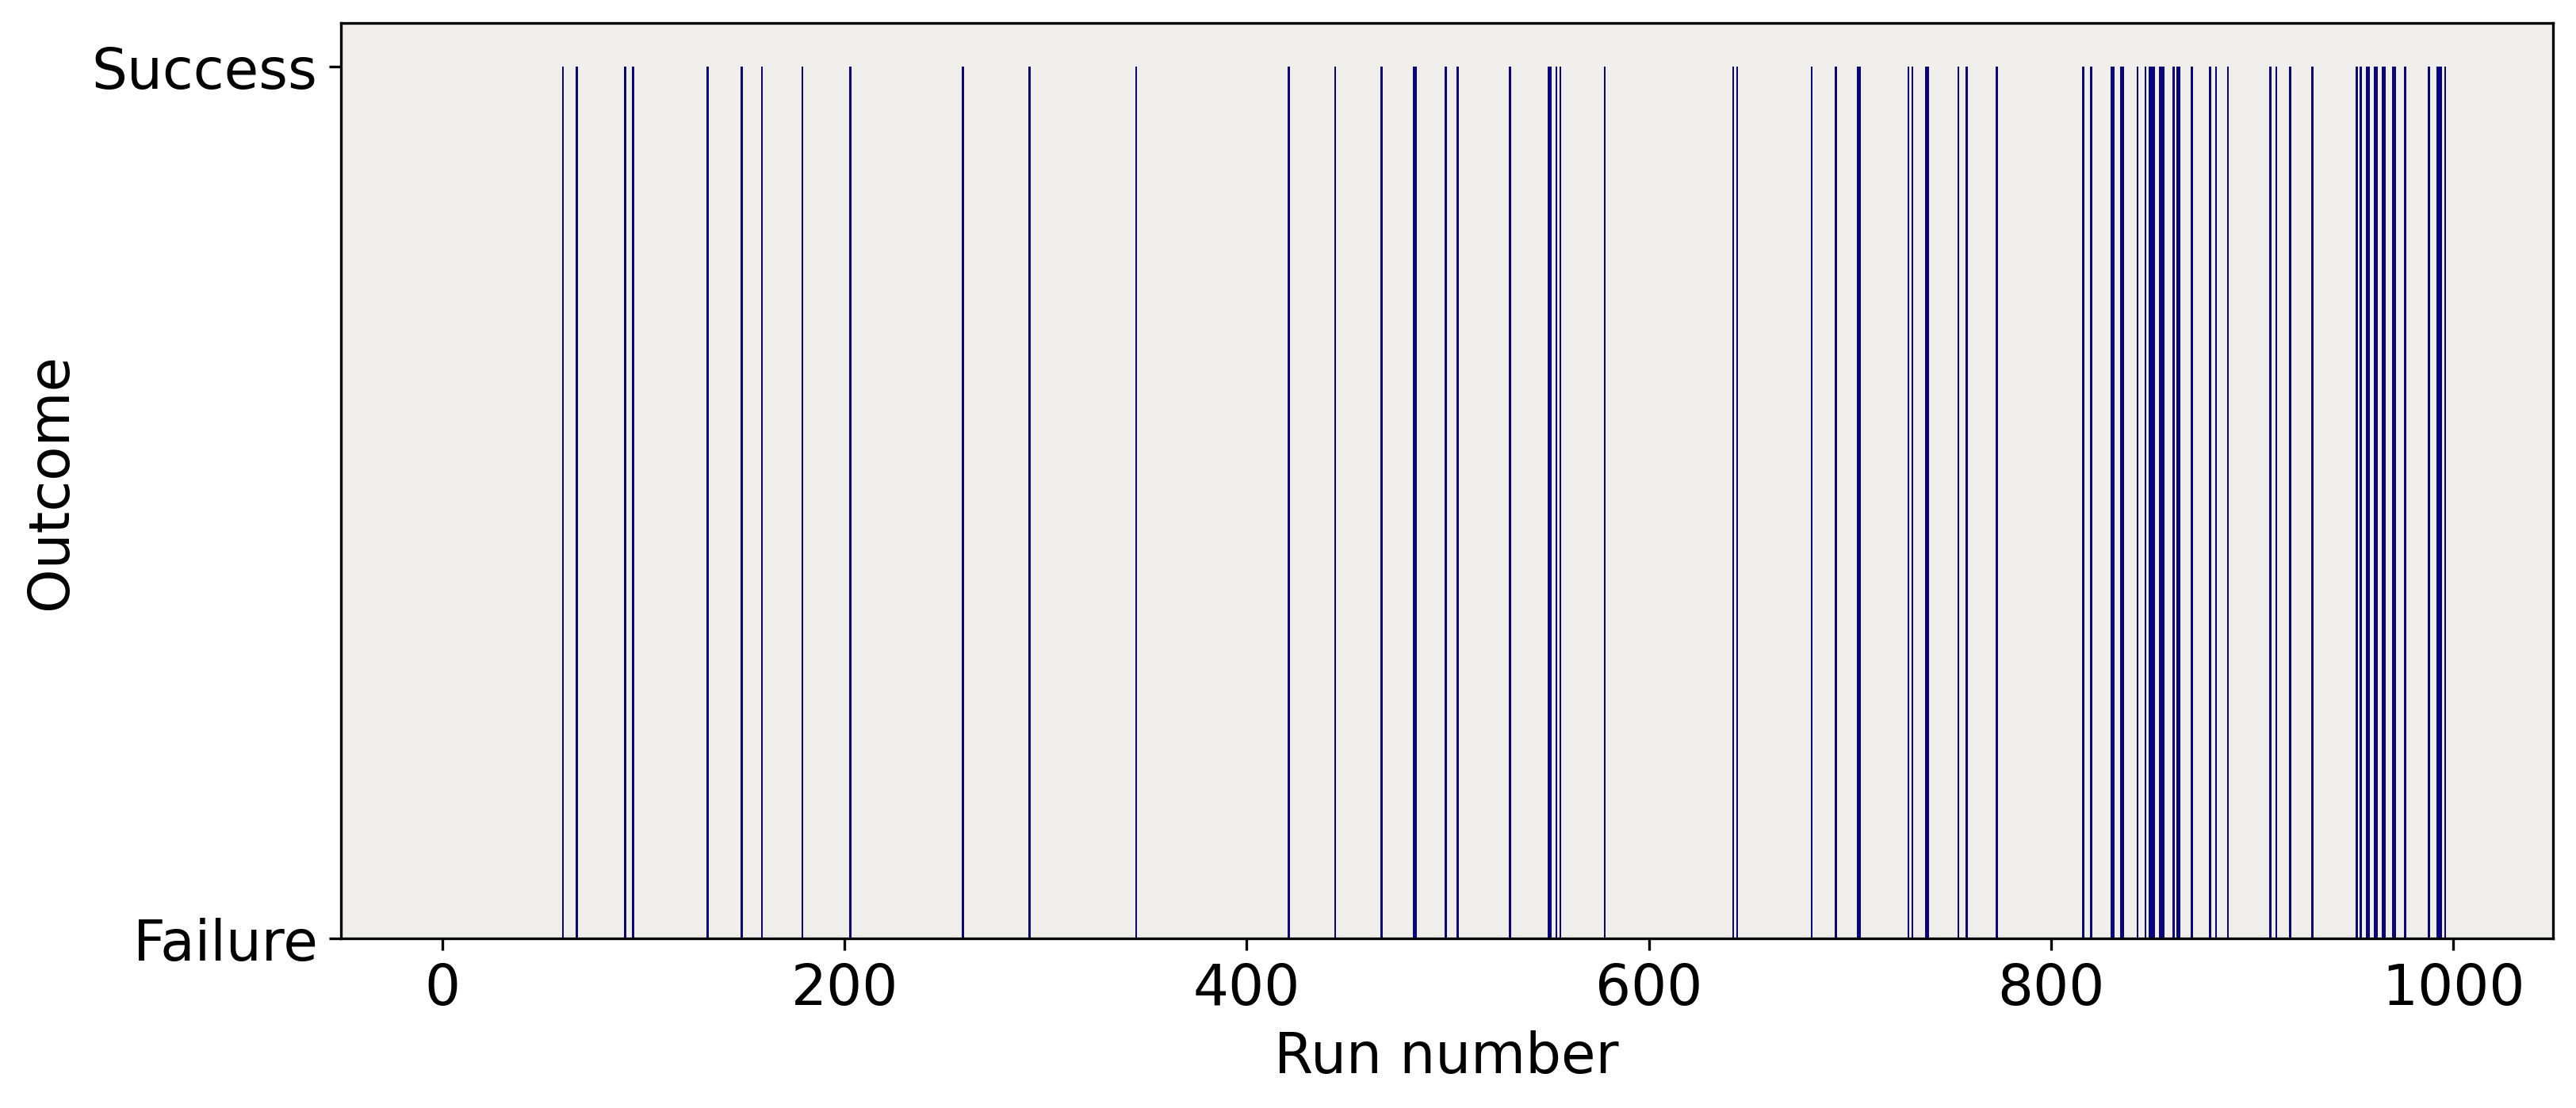

In [19]:
# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()

In [20]:
episodes = 100
nb_success = 0

# Evaluation
for _ in range(100):
    state = environment.reset()
    state = environment.action_space.sample()
    done = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

# Let's check our success rate!
print(f"Success rate = {nb_success / episodes * 100}%")


Success rate = 24.0%
